**Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from transformers import AdamW
from transformers import RobertaForSequenceClassification,RobertaTokenizer
from transformers import RobertaTokenizerFast,RobertaForMaskedLM,RobertaModel
from transformers import DebertaTokenizer, DebertaModel,DebertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoConfig

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Data Visualization**

In [3]:
df = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/edos_labelled_aggregated.csv')
df = df[df['label_sexist'] == "sexist"]
print(df.head)

# for task A we don't need these things
df.drop(['rewire_id','label_sexist','label_category'], axis=1, inplace=True)

<bound method NDFrame.head of                       rewire_id  \
6       sexism2022_english-7228   
8        sexism2022_english-872   
9       sexism2022_english-3553   
14     sexism2022_english-14992   
15     sexism2022_english-13328   
...                         ...   
19983  sexism2022_english-17659   
19984  sexism2022_english-13737   
19986   sexism2022_english-8065   
19992  sexism2022_english-12176   
19999   sexism2022_english-3523   

                                                    text label_sexist  \
6      [USER] Leg day is easy. Hot girls who wear min...       sexist   
8      I get a new pussy every other week or whenever...       sexist   
9      I agree with that but at the same time I know ...       sexist   
14     O come on there's no way any men are attracted...       sexist   
15     democrats from Minnesota (leftist muzzie shith...       sexist   
...                                                  ...          ...   
19983  This is easily the dumbest thin

In [4]:
dfTrain=df[df['split']=="train"]
dfVal=df[df['split']=="dev"]
dfTest=df[df['split']=="test"]
#df.drop(['rewire_id','label_category','label_vector'], axis=1, inplace=True)

In [5]:
dfTrain.drop(['split'], axis=1, inplace=True)
dfVal.drop(['split'], axis=1, inplace=True)
dfTest.drop(['split'], axis=1, inplace=True)
print(dfTrain.shape,dfVal.shape,dfTest.shape)

(3398, 2) (486, 2) (970, 2)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
print(dfTrain.head())

                                                 text  \
6   [USER] Leg day is easy. Hot girls who wear min...   
8   I get a new pussy every other week or whenever...   
14  O come on there's no way any men are attracted...   
26  Former BBC journalist Thuto Mali says that uni...   
32  I did. You have to have the bravery to escalat...   

                                         label_vector  
6                 3.3 backhanded gendered compliments  
8   2.3 dehumanising attacks & overt sexual object...  
14  2.3 dehumanising attacks & overt sexual object...  
26  4.2 supporting systemic discrimination against...  
32           1.2 incitement and encouragement of harm  


In [7]:
freq=df['label_vector'].value_counts().to_dict()
print(freq)

{'2.1 descriptive attacks': 1024, '2.2 aggressive and emotive attacks': 961, '3.1 casual use of gendered slurs, profanities, and insults': 910, '3.2 immutable gender differences and gender stereotypes': 596, '4.2 supporting systemic discrimination against women as a group': 368, '1.2 incitement and encouragement of harm': 363, '2.3 dehumanising attacks & overt sexual objectification': 286, '4.1 supporting mistreatment of individual women': 107, '3.3 backhanded gendered compliments': 91, '1.1 threats of harm': 80, '3.4 condescending explanations or unwelcome advice': 68}


**Distibution of sexist and non sexist text labels**

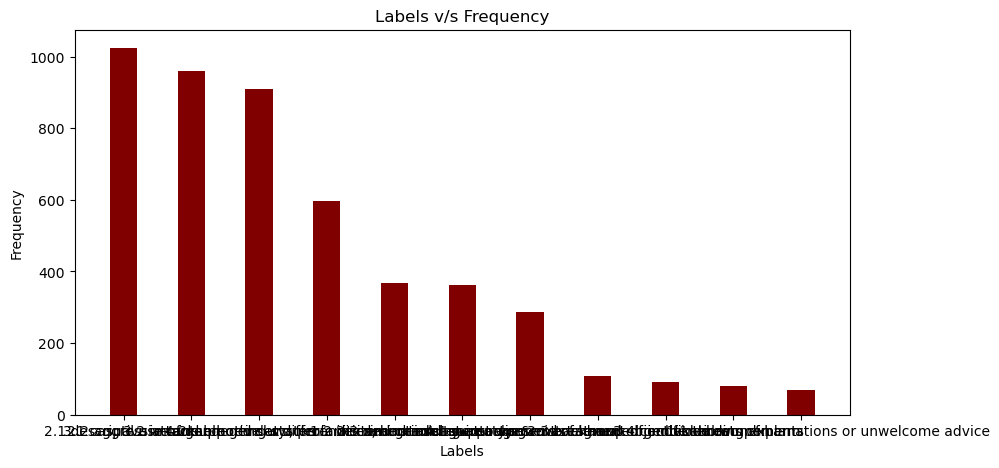

In [8]:
data = freq
types = list(data.keys())
frequency = list(data.values())

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.show()

**Dataset to Lists**

**Distibution of Numbers of words in each text**

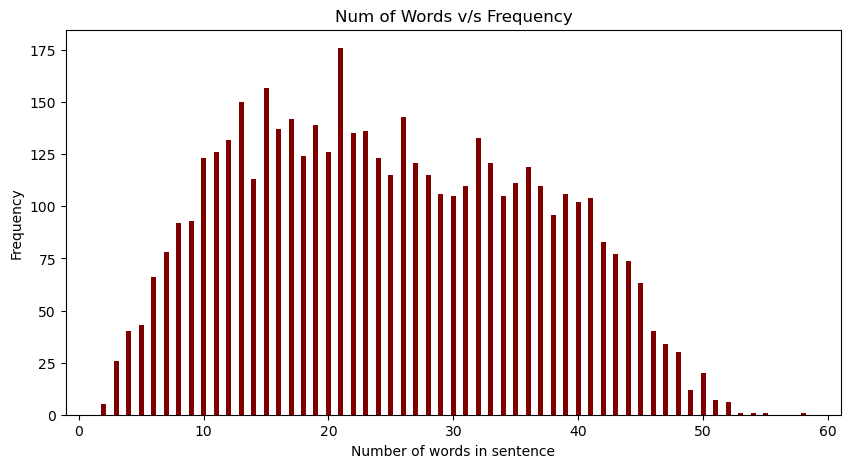

In [9]:
freq={}
texts=df['text'].tolist()
for sentence in texts:
    num_text=len(sentence.split())
    if num_text not in freq:
        freq[num_text]=0
    freq[num_text]+=1

types = list(freq.keys())
frequency = list(freq.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Number of words in sentence")
plt.ylabel("Frequency")
plt.title("Num of Words v/s Frequency")
plt.show()

**Data Cleaning Modul** But not used

In [10]:
class DataCleaning():
    """
        Take a list of strings and preprocess strings, it preforms:
        
    """
    def __init__(self, list_data):
        self.data = list_data
        self.len = len(list_data)

    def clean_data(self):
        self.emojis_to_text()
        self.lowerCase()
        self.linkToTag()
        self.removePunctuations()
        self.removeWordsWithNumber()
        
    def tokenizer():
        pass
        
    def rootWord(self,lemmatizer=False):
        """
            Steamer is faster than lammatization.
            Steamer cut the last few words, and use the root word
            lemmatizer convert many form a word to the same word. 
            stemmer will retun 'car' for word 'caring'
            while lemmatizer return 'care' for 'caring'
        """
        if not lemmatizer:
            stemmer = PorterStemmer()
            for i in range(self.len):
                self.data[i]=" ".join([stemmer.stem(word) for word in self.data[i].split()])
        else:
            lemmatizer = WordNetLemmatizer()
            for i in range(self.len):
                self.data[i]=" ".join([lemmatizer.lemmatize(word) for word in self.data[i].split()])
        
    def removePunctuations(self):
        removePunc = re.compile(r'[^\w\s]')
        for i in range(self.len):
            self.data[i] = re.sub(removePunc, r" ",self.data[i])

    def emojis_to_text(self):
        """
            Converting image to its text meaning.
            Format: 👍 to ":thumbs_up:"
        """
        for i in range(self.len):
            self.data[i]=emoji.demojize(self.data[i])
            
    def linkToTag(self):
        """replacing web links with '<URL>'"""
        linkRegex = re.compile(r'\b(www|http|https)[^ |\n]*')

        for i in range(self.len):
            self.data[i] = re.sub(linkRegex, r"<URL>",self.data[i])
    
    def removeWordsWithNumber(self):
        """
            Zero or more number of non-whitespace then digit, 
            then Zero or more number of non-whitespace
        """
        wordNumRegex = re.compile(r'\S*\d\S*')
        for i in range(self.len):
            self.data[i]=re.sub(wordNumRegex,r"",self.data[i])
    
    def lowerCase(self):
        """
            It is sometimes important to keep the letter capital 
            as it signifies shouting in form of that word, but it
            depends on use case
        """
        for i in range(self.len):
            self.data[i]=self.data[i].lower()
            
    def removeStopword(self):
        """ Remove stopward from a string"""
        stop = stopwords.words('english')
        for i in range(self.len):
            self.data[i]=' '.join([word for word in self.data[i].split() if word not in stop])

In [11]:
#cleaning=DataCleaning(texts)
#cleaning.clean_data()
#texts=cleaning.data

**Loading Model**

In [12]:
preTrainedModel=True

if preTrainedModel == False:
    print('Loading Base model')
    roberta = RobertaModel.from_pretrained("roberta-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    
    deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', use_fast=True, do_lower_case=False, max_len=64)
    deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
    
else:
    print("Loading Domain Adaptive Pretrained Model")
    roberta_modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt"
    roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_modelpath, use_fast = False, do_lower_case=True)
    roberta = RobertaModel.from_pretrained(roberta_modelpath)

    print("\n")
    
    deberta_modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta"
    deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_modelpath, use_fast = False, do_lower_case=True)
    deberta = DebertaModel.from_pretrained(deberta_modelpath)

Loading Domain Adaptive Pretrained Model


Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt and are newly initialized: ['roberta.pooler.dense

Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta were not used when initializing DebertaModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Converting Train Data to Data Loader format**

In [13]:
MAX_LENGHT = 64
batch_size = 64

In [14]:
def loader(df,batch_size=128,train=True,MAX_LENGHT=64):
    """
        Given a dataframe it will return a dataloader
    """

    texts=df['text'].tolist()
    labels=df['label_vector'].tolist()
    
    tokens_roberta = roberta_tokenizer.batch_encode_plus(texts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    tokens_deberta = deberta_tokenizer.batch_encode_plus(texts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    
    seq_roberta = torch.tensor(tokens_roberta['input_ids'],device=device)
    mask_roberta = torch.tensor(tokens_roberta['attention_mask'],device=device)

    seq_deberta = torch.tensor(tokens_deberta['input_ids'],device=device)
    mask_deberta = torch.tensor(tokens_deberta['attention_mask'],device=device)
    
    # 1 for sexist and 0 for non sexist
    y=[]
    for label in labels:
        if label=="1.1 threats of harm":
            y.append(0)
        elif label=="1.2 incitement and encouragement of harm":
            y.append(1)
        elif label=="2.1 descriptive attacks":
            y.append(2)
        elif label=="2.2 aggressive and emotive attacks":
            y.append(3)
        elif label=="2.3 dehumanising attacks & overt sexual objectification":
            y.append(4)
        elif label=="3.1 casual use of gendered slurs, profanities, and insults":
            y.append(5)
        elif label=="3.2 immutable gender differences and gender stereotypes":
            y.append(6)
        elif label=="3.3 backhanded gendered compliments":
            y.append(7)
        elif label=="3.4 condescending explanations or unwelcome advice":
            y.append(8)
        elif label=="4.1 supporting mistreatment of individual women":
            y.append(9)
        else: #4.2 supporting systemic discrimination against women as a group
            y.append(10)
            
    y = torch.tensor(y,device=device)
    
    data = TensorDataset(seq_roberta, mask_roberta,seq_deberta, mask_deberta, y)    
    if train:
        dataloader = DataLoader(data, shuffle=True, batch_size=batch_size)
    else:
        dataloader = DataLoader(data,batch_size=batch_size,shuffle=False)

    return dataloader

In [15]:
trainDataLoader=loader(dfTrain,batch_size=batch_size,train=True)
valDataLoader= loader(dfVal,batch_size=batch_size,train=False)
testDataLoader= loader(dfTest,batch_size=batch_size,train=False)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Weights of base model will change**

In [16]:
for param in roberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed
    
for param in deberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed

**Model**

In [17]:
class RoBERT_Arch(nn.Module):
    def __init__(self, roberta,deberta):  
        super(RoBERT_Arch, self).__init__()
        self.roberta = roberta
        self.deberta = deberta
        self.dropout = nn.Dropout(0.1)            
        self.relu =  nn.ReLU()                    
                    
        self.fcL1=nn.Linear(768,512)
        self.fcL2=nn.Linear(512,256)
            
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,11)  
        
        self.softmax = nn.LogSoftmax(dim=1)       
    
    def forward(self, sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta):            
        cls_hs1 = self.roberta(sent_id_roberta, attention_mask=mask_roberta)
        cls_hs2 = self.deberta(sent_id_deberta, attention_mask=mask_deberta)
        
        hidden_state1 = cls_hs1[0]
        cls_hs1 = hidden_state1[:, 0]
        
        hidden_state2 = cls_hs2[0]
        cls_hs2 = hidden_state2[:, 0]
        
        x1=self.fcL1(cls_hs1)
        x1=self.fcL2(x1)
        
        x2=self.fcL1(cls_hs2)
        x2=self.fcL2(x2)
        
        x=torch.cat((x1,x2),1)
        
        x = self.fc1(x)
        x = self.relu(x)    
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x) #Activation function,followed by dropout , in case of relu it is same
        x = self.dropout(x)
        x = self.fc3(x)    
        x = self.softmax(x)      
        return x

model = RoBERT_Arch(roberta,deberta)
model= nn.DataParallel(model)
model = model.to(device)

**Hyperparameter**

In [18]:
optimizer = AdamW(model.parameters(),lr = 1e-5)         
cross_entropy  = nn.NLLLoss() 
epochs = 20

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**Training**

In [19]:
def train(train_dataloader,val_dataloader,useFullData=False):  
    model.train()
    total_loss=0
    dataloader=[train_dataloader]
    
    if useFullData:
        dataloader=[val_dataloader]
  
    for loader in dataloader:
        for step,batch in enumerate(tqdm(loader,position=0, leave=True)):                               
            sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta,labels = batch 
            model.zero_grad()                                          
            preds = model(sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta)          
        
            loss = cross_entropy(preds, labels)   
        
            loss.backward()                                             
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
            optimizer.step()    
            total_loss = total_loss + loss.item()                    
    
    # checking validation accuracy
    if useFullData==False:
        model.eval()
        with torch.no_grad():
            val_preds=[]
            actual=[]
            for step,batch in enumerate(tqdm(val_dataloader,position=0, leave=True)):          
                                         
                sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta, labels = batch 
            
                preds = model(sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta)           
                preds = torch.argmax(preds,dim=1)
                val_preds+=preds.tolist()                         
                actual+=labels.tolist()
            valf1=f1_score(val_preds,actual,average="macro")
        return total_loss,valf1
    return total_loss,None # in this we are training on validation to get final model
    # so no use of testing on validation data itself

**Training from Train Data**

In [20]:
counter=1
lossT=[]
val_f1=[]
epochs=18 #memory is getting full
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    total_loss,f1 = train(trainDataLoader,valDataLoader)            
    lossT.append(total_loss)
    val_f1.append(f1)
    print('Training Loss: ',total_loss)
    print("Validation F1 score: ",f1)
    torch.save(model.state_dict(), 'Multi_MLP_Concat_base_dptc'+str(counter)+".pt")
    counter+=1


 Epoch 1 / 18


100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


Training Loss:  124.82699465751648
Validation F1 score:  0.02999062792877226

 Epoch 2 / 18


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Training Loss:  116.42937803268433
Validation F1 score:  0.08337065233616957

 Epoch 3 / 18


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Training Loss:  110.17932415008545
Validation F1 score:  0.12346281951603459

 Epoch 4 / 18


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Training Loss:  101.48886501789093
Validation F1 score:  0.1107892856236966

 Epoch 5 / 18


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Training Loss:  94.61774599552155
Validation F1 score:  0.13883836070820113

 Epoch 6 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  89.13389801979065
Validation F1 score:  0.15714824509717476

 Epoch 7 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  83.78069198131561
Validation F1 score:  0.20060972253398895

 Epoch 8 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  78.63406276702881
Validation F1 score:  0.24419321118301054

 Epoch 9 / 18


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Training Loss:  72.84434533119202
Validation F1 score:  0.26602854035541196

 Epoch 10 / 18


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Training Loss:  67.74270415306091
Validation F1 score:  0.28487566070058307

 Epoch 11 / 18


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Training Loss:  61.60962492227554
Validation F1 score:  0.306560567891

 Epoch 12 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  56.52107471227646
Validation F1 score:  0.3129747485412024

 Epoch 13 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  51.448265969753265
Validation F1 score:  0.3150596698967267

 Epoch 14 / 18


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Training Loss:  46.728567719459534
Validation F1 score:  0.3210120110897912

 Epoch 15 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  42.05357113480568
Validation F1 score:  0.3339108775535016

 Epoch 16 / 18


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Training Loss:  36.25121030211449
Validation F1 score:  0.328745659305055

 Epoch 17 / 18


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Training Loss:  31.678376704454422
Validation F1 score:  0.35309992825024233

 Epoch 18 / 18


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


Training Loss:  28.383394926786423
Validation F1 score:  0.30759496889575844


**Load Model:** Loading the model with good Macro F1 score and then using validation data as well to train over it

In [21]:
path = "/kaggle/working/Multi_MLP_Concat_base_dptc17.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Plotting Training Loss and Validation Macro F1 score**

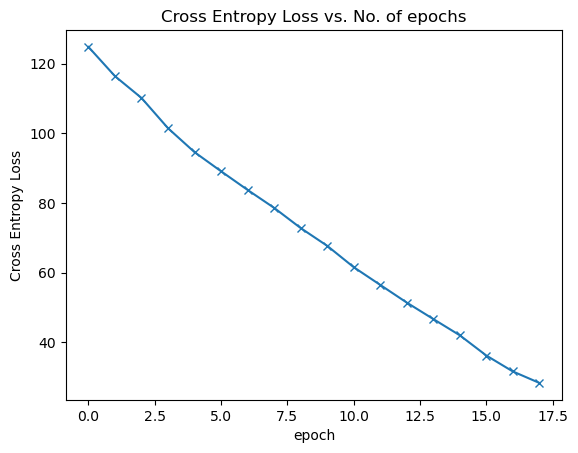

In [22]:
def plot_losses(losses):
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Cross Entropy Loss vs. No. of epochs')
    
plot_losses(lossT)

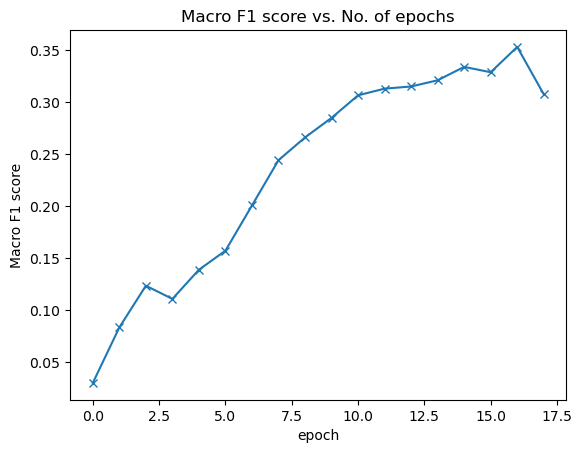

In [23]:
def plot_score(f1):
    plt.plot(f1, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Macro F1 score')
    plt.title('Macro F1 score vs. No. of epochs')
    
plot_score(val_f1)

**Now using validation data to train as well**

In [24]:
counter=1
epochs=10
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    _L,_ = train(trainDataLoader,valDataLoader,True)


 Epoch 1 / 10


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



 Epoch 2 / 10


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



 Epoch 3 / 10


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



 Epoch 4 / 10


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



 Epoch 5 / 10


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



 Epoch 6 / 10


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



 Epoch 7 / 10


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]



 Epoch 8 / 10


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



 Epoch 9 / 10


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



 Epoch 10 / 10


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


**F1 score for Test Data**

In [25]:
#checking test accuracy    
def testAccuracy(test_dataloader,model):
    model.eval()
    with torch.no_grad():
        test_preds=[]
        actual=[]
        for step,batch in enumerate(tqdm(test_dataloader,position=0, leave=True)):          
                                           
            sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta, labels = batch 
            
            preds = model(sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta)          
            preds = torch.argmax(preds,dim=1)
            test_preds+=preds.tolist()                         
            actual+=labels.tolist()
        testf1=f1_score(test_preds,actual,average="macro")
    
    return testf1

In [26]:
testf1=testAccuracy(testDataLoader,model)
print("Test Accuracy is: ",testf1)

100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

Test Accuracy is:  0.3693137564613785


In [27]:
def Inference(testTexts):
    """
        Takes a list of texts
        No backpropogation. Better way to do this, is with dataloader
    """
    tokens_test_roberta = roberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    tokens_test_deberta = deberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    

    test_seq_roberta = torch.tensor(tokens_test_roberta['input_ids'],device=device)
    test_mask_roberta = torch.tensor(tokens_test_roberta['attention_mask'],device=device)

    test_seq_deberta = torch.tensor(tokens_test_deberta['input_ids'],device=device)
    test_mask_deberta = torch.tensor(tokens_test_deberta['attention_mask'],device=device)
    
    
    model.eval()
    with torch.no_grad():
        preds = model(test_seq_roberta, test_mask_roberta,test_seq_deberta, test_mask_deberta)
        preds = preds.detach().cpu().numpy()
    
    preds = np.argmax(preds, axis = 1)
    
    label_pred=[]

    for label in preds:
        if label == 0:
            label_pred.append('1.1 threats of harm')
        elif label == 1:
            label_pred.append('1.2 incitement and encouragement of harm')
        elif label == 2:
            label_pred.append('2.1 descriptive attacks')
        elif label == 3:
            label_pred.append('2.2 aggressive and emotive attacks')
        elif label == 4:
            label_pred.append('2.3 dehumanising attacks & overt sexual objectification')
        elif label == 5:
            label_pred.append('3.1 casual use of gendered slurs, profanities, and insults')
        elif label == 6:
            label_pred.append('3.2 immutable gender differences and gender stereotypes')
        elif label == 7:
            label_pred.append('3.3 backhanded gendered compliments')
        elif label == 8:
            label_pred.append('3.4 condescending explanations or unwelcome advice')
        elif label == 9:
            label_pred.append('4.1 supporting mistreatment of individual women')
        else:
            label_pred.append('4.2 supporting systemic discrimination against women as a group')
    
    return "The text is "+label_pred[0]

In [28]:
data=["Hey, Have a good day ahead"]
Inference(data)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'The text is 2.3 dehumanising attacks & overt sexual objectification'

In [29]:
torch.save(model.state_dict(), 'Multi_MLP_Concat_base_final_dptC.pt')